# Single-cell Proteomics Synthetic Data Generation

The goal of this notebook is to simulate a crude single-cell proteomics datasets with a MNAR mechanism, and show that not-MIWAE performs better than MIWAE.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from MIWAE import MIWAE
from notMIWAE import notMIWAE
import trainer
import utils

np.random.seed(42)

2023-11-09 23:24:15.789939: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-09 23:24:15.791808: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-09 23:24:15.821190: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 23:24:15.821221: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 23:24:15.821247: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Plotting functions for later.

In [2]:
def scatter_compare_individual_entries_panel(x_obs, x_miss, x_est_obs, x_est_miss):
    fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
    
    ax = axes[0]
    ax.scatter(x_obs, x_est_obs, s=1, alpha=0.1)
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
    ax.plot(lims, lims, "--", c="k")

    mse = np.mean((x_obs - x_est_obs)**2)
    ax.text(0.05, 0.95, f"MSE: {mse:.2f}", transform=ax.transAxes, fontsize=12, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.8))

    ax.set_xlabel("Observed")
    ax.set_ylabel("Imputed")
    ax.set_title("Observed")
    ax.grid(True)
    ax.set_axisbelow(True)

    ax = axes[1]
    ax.scatter(x_miss, x_est_miss, s=1, alpha=0.1)
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
    ax.plot(lims, lims, "--", c="k")

    mse = np.mean((x_miss - x_est_miss)**2)
    ax.text(0.05, 0.95, f"MSE: {mse:.2f}", transform=ax.transAxes, fontsize=12, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.8))

    ax.set_xlabel("Observed")
    ax.set_ylabel("Imputed")
    ax.set_title("Missing")
    ax.grid(True)

In [3]:
def hist_compare_individual_entries(x_obs, x_miss, x_est_obs, x_est_miss):
    fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

    x_min = np.min([np.min(x_obs), np.min(x_miss), np.min(x_est_obs), np.min(x_est_miss)])
    x_max = np.max([np.max(x_obs), np.max(x_miss), np.max(x_est_obs), np.max(x_est_miss)])

    ax = axes[0]
    ax.hist([x_obs, x_miss], color=["blue", "red"], bins=50, edgecolor="black", linewidth=1.2, stacked=True)
    ax.set_title("Data")
    ax.set_xlabel("x")
    ax.set_ylabel("(stacked) count")
    ax.set_xlim(x_min, x_max)
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.legend(labels=["$x_{obs}$", "$x_{miss}$"], fontsize=12)

    ax = axes[1]
    ax.hist([x_est_obs, x_est_miss], color=["blue", "red"], bins=50, edgecolor="black", linewidth=1.2, stacked=True)
    ax.set_title("Model")
    ax.set_xlabel("x")
    ax.set_ylabel("(stacked) count")
    ax.set_xlim(x_min, x_max)
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.legend(labels=["$x_{obs}$", "$x_{miss}$"], fontsize=12)

## Data generation

Let's start by generating the synthetic data and visualizing it.

In [4]:
def logistic(x, k=1, x0=0, L=1):
    return L / (1 + np.exp(-k * (x - x0)))


def simulate_data(n_cells=1000, n_proteins=900):
    # all cells are from the same group (cell-type)
    # the cell type has some protein distribution / signature
    cell_type_signature = np.random.uniform(5, 12, n_proteins)

    # each cell is a bit different
    cell_variation = np.random.normal(0, 1, n_cells)

    intensity = cell_type_signature.reshape(1, -1) + cell_variation.reshape(-1, 1)

    # the measurement is noisy
    x = np.random.normal(intensity, 0.1)

    # MNAR mechanism: self-masking (x -> m)
    # entries with low intensity are less likely to be sampled
    detection_prob = logistic(x, k=2, x0=7) # set x0=6, if you want less missing values

    # sample using a bernoulli distribution
    mask = np.random.binomial(1, detection_prob)
    mask = mask.astype(bool)

    return x, detection_prob, mask

Let's simulate some data:

In [5]:
x_data, detection_prob, mask = simulate_data()

In [6]:
x_nan = x_data.copy()
x_nan[~mask] = np.nan

x_0 = x_data.copy()
x_0[~mask] = 0

In [7]:
print("Missing entries: {:.2f}%".format(np.isnan(x_nan).sum() / x_nan.size * 100))

Missing entries: 29.27%


Let's plot the data. "White" are the missing values.

Text(0.5, 1.0, 'Expression matrix with missing values')

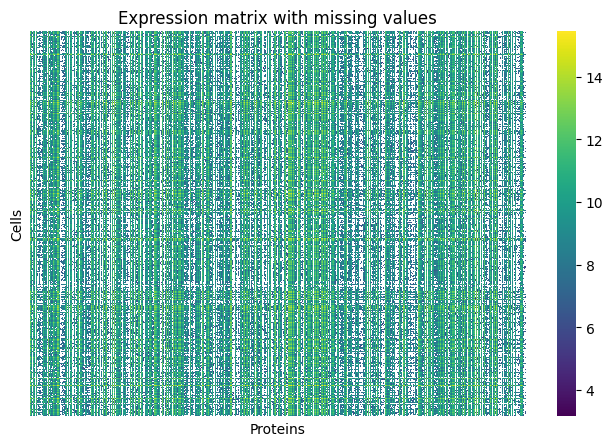

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(x_nan, cmap="viridis", xticklabels=False, yticklabels=False, ax=ax)
ax.set_xlabel("Proteins")
ax.set_ylabel("Cells")
ax.set_title("Expression matrix with missing values")

Let's look at the missigness pattern entry-wise and protein-wise:

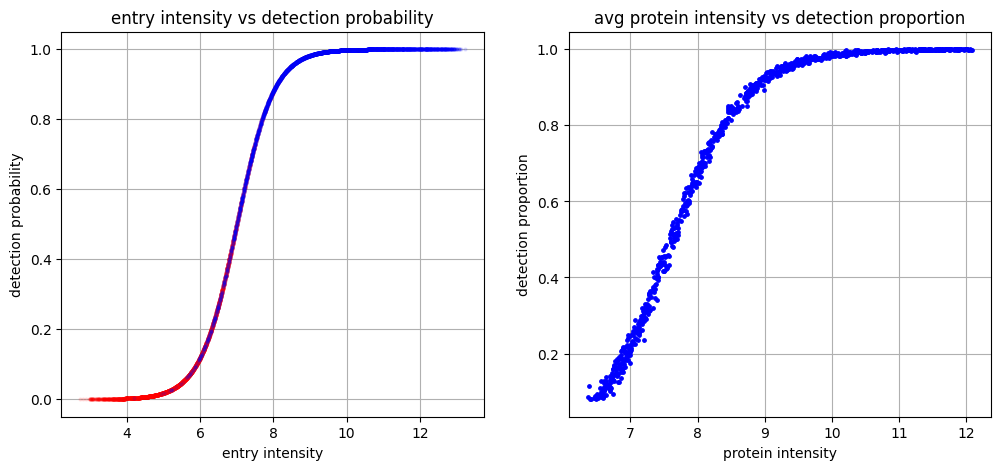

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

# plot entry intensity vs detection probability
ax = axes[0]

p_obs = detection_prob[mask]
x_obs = x_data[mask]

p_miss = detection_prob[~mask]
x_miss = x_data[~mask]

n = 5_000

ax.scatter(x_miss[:n], p_miss[:n], color="red", alpha=.1, s=4)
ax.scatter(x_obs[:n], p_obs[:n], color="blue", alpha=.1, s=4)
ax.set_title("entry intensity vs detection probability")
ax.set_xlabel("entry intensity")
ax.set_ylabel("detection probability")
ax.grid(True)
ax.set_axisbelow(True)

# plot the average protein intensity vs the detection proportion
ax = axes[1]
x_obs_protein = np.nanmean(x_nan, axis=0)
p_protein = 1 - np.nanmean(np.isnan(x_nan), axis=0)

ax.scatter(x_obs_protein, p_protein, color="blue", alpha=1, s=6)
ax.set_title("avg protein intensity vs detection proportion")
ax.set_xlabel("protein intensity")
ax.set_ylabel("detection proportion")
ax.grid(True)
ax.set_axisbelow(True)


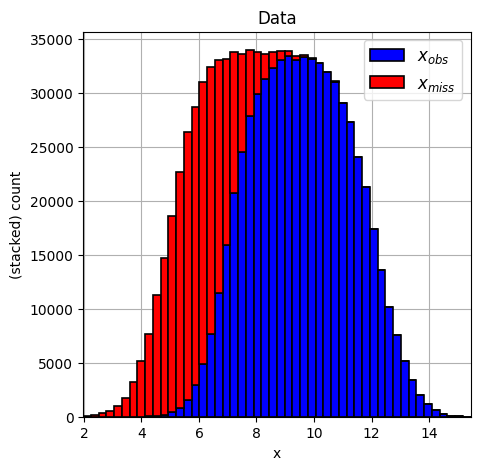

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.hist([x_obs, x_miss], color=["blue", "red"], bins=50, edgecolor="black", linewidth=1.2, stacked=True)
ax.set_title("Data")
ax.set_xlabel("x")
ax.set_ylabel("(stacked) count")
ax.set_xlim(np.min(x_data), np.max(x_data))
ax.grid(True)
ax.set_axisbelow(True)
ax.legend(labels=["$x_{obs}$", "$x_{miss}$"], fontsize=12)

## Model Comparison

Set the parameters for the models.

In [11]:
name = '/tmp/best'

# model specification
n_hidden = 128
n_samples = 20
n_latent = 16
mprocess = 'selfmasking' #'selfmasking_known'
out_dist='gauss'

# training
max_iter = 20_000
batch_size = 32

# imputation
L = 10000

Let's run.

In [12]:
N, D = x_data.shape

Xtrain = x_data.copy()
Xval_org = x_data.copy()

Xnan = x_nan.copy()
Xz = x_0.copy()
S = mask.copy()

Xval = x_nan.copy()
Xvalz = x_0.copy()

In [13]:
tf.compat.v1.disable_eager_execution()

### MIWAE

In [14]:
miwae = MIWAE(Xnan, Xval, n_latent=n_latent, n_samples=n_samples, n_hidden=n_hidden, name=name, out_dist=out_dist)

# ---- do the training
trainer.train(miwae, batch_size=batch_size, max_iter=max_iter, name=name + 'miwae')

# ---- find imputation RMSE
RMSE_miwae, x_miwae = utils.imputationRMSE(miwae, Xtrain, Xz, Xnan, S, L)

np.save('x_miwae.npy', x_miwae)

Creating graph...


2023-11-09 23:24:20.281736: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled


Saving session...
Saving session...
0/20000 updates, 0.29 s, 61432.24 train_loss, 63506.62 val_loss
Saving session...
100/20000 updates, 2.47 s, 1952.50 train_loss, 1975.86 val_loss
Saving session...
200/20000 updates, 2.76 s, 1597.45 train_loss, 1547.73 val_loss
Saving session...
300/20000 updates, 2.99 s, 1322.30 train_loss, 1300.55 val_loss
Saving session...
400/20000 updates, 2.61 s, 1055.80 train_loss, 1012.46 val_loss
Saving session...
500/20000 updates, 3.06 s, 674.04 train_loss, 683.17 val_loss
Saving session...
600/20000 updates, 2.60 s, 482.29 train_loss, 509.41 val_loss
Saving session...
700/20000 updates, 2.33 s, 626.90 train_loss, 242.90 val_loss
Saving session...
800/20000 updates, 2.56 s, 205.76 train_loss, 235.69 val_loss
Saving session...
900/20000 updates, 2.70 s, -18.18 train_loss, -19.20 val_loss
Saving session...
1000/20000 updates, 2.64 s, -88.92 train_loss, -34.43 val_loss
Saving session...
1100/20000 updates, 2.87 s, 36.40 train_loss, -41.15 val_loss
Saving sess

In [15]:
print("RMSE: {:.3f}".format(RMSE_miwae))

RMSE: 0.231


In [16]:
x_miwae = np.load('x_miwae.npy')

In [17]:
x_obs = x_data[mask]
x_miss = x_data[~mask]

x_est = x_miwae

x_est_obs = x_est[mask]
x_est_miss = x_est[~mask]

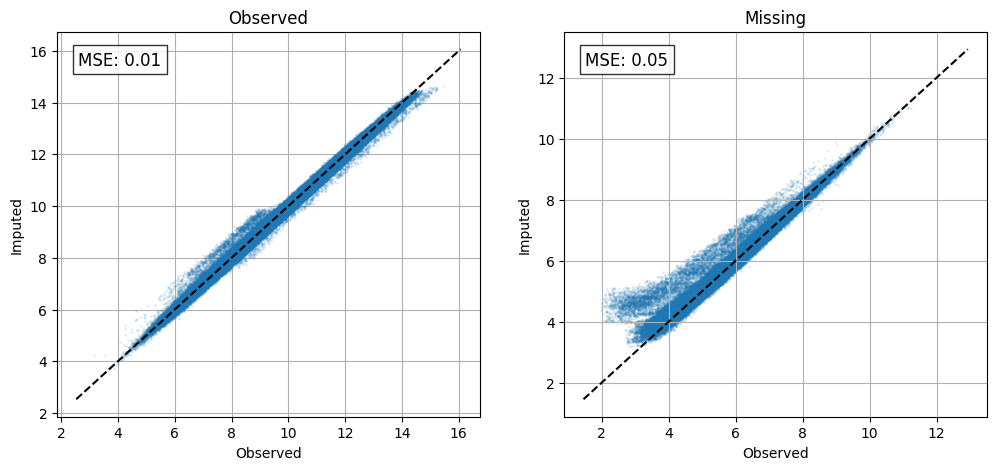

In [18]:
scatter_compare_individual_entries_panel(x_obs, x_miss, x_est_obs, x_est_miss)

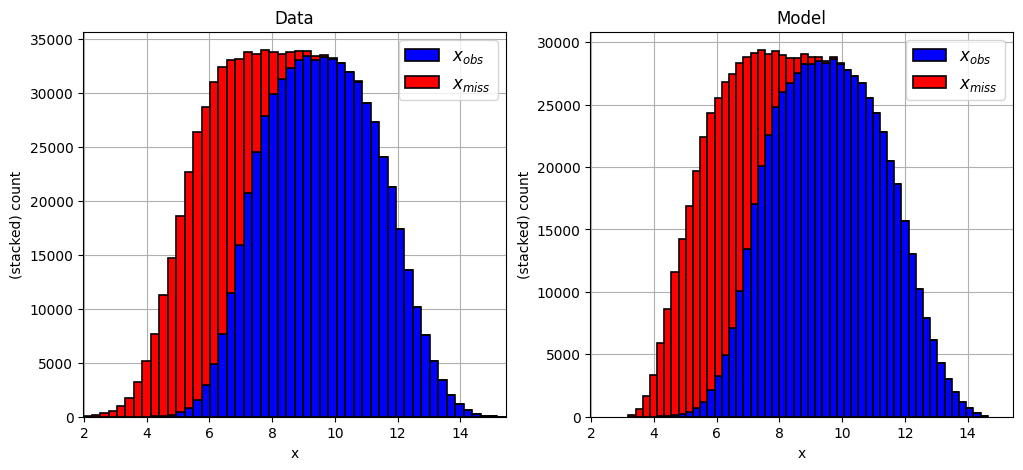

In [19]:
hist_compare_individual_entries(x_obs, x_miss, x_est_obs, x_est_miss)

### not-MIWAE

In [20]:
notmiwae = notMIWAE(Xnan, Xval, n_latent=n_latent, n_samples=n_samples, n_hidden=n_hidden, missing_process=mprocess, name=name, out_dist=out_dist)

# ---- do the training
trainer.train(notmiwae, batch_size=batch_size, max_iter=max_iter, name=name + 'notmiwae')

# ---- find imputation RMSE
RMSE_notmiwae, x_notmiwae = utils.not_imputationRMSE(notmiwae, Xtrain, Xz, Xnan, S, L)

np.save('x_notmiwae.npy', x_notmiwae)

Creating graph...
Saving session...
Saving session...
0/20000 updates, 0.17 s, 61831.96 train_loss, 63107.09 val_loss
Saving session...
100/20000 updates, 3.87 s, 2420.93 train_loss, 2403.87 val_loss
Saving session...
200/20000 updates, 3.91 s, 2043.27 train_loss, 2002.58 val_loss
Saving session...
300/20000 updates, 4.22 s, 1806.88 train_loss, 1766.99 val_loss
Saving session...
400/20000 updates, 4.12 s, 1446.58 train_loss, 1473.05 val_loss
Saving session...
500/20000 updates, 4.24 s, 1066.23 train_loss, 1121.69 val_loss
Saving session...
600/20000 updates, 4.11 s, 790.09 train_loss, 849.09 val_loss
Saving session...
700/20000 updates, 4.14 s, 557.01 train_loss, 586.51 val_loss
Saving session...
800/20000 updates, 4.09 s, 459.50 train_loss, 455.72 val_loss
900/20000 updates, 4.28 s, 536.35 train_loss, 532.68 val_loss
1000/20000 updates, 4.05 s, 399.57 train_loss, 516.68 val_loss
Saving session...
1100/20000 updates, 4.20 s, 452.03 train_loss, 373.31 val_loss
1200/20000 updates, 4.11 s

In [21]:
print("RMSE: {:.3f}".format(RMSE_notmiwae))

RMSE: 2.017


In [22]:
x_notmiwae = np.load('x_notmiwae.npy')

In [23]:
x_obs = x_data[mask]
x_miss = x_data[~mask]

x_est = x_notmiwae

x_est_obs = x_est[mask]
x_est_miss = x_est[~mask]

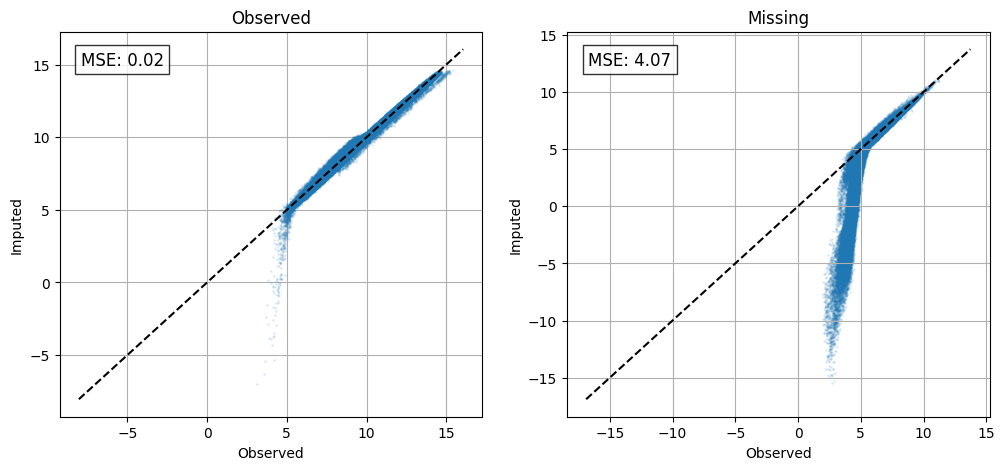

In [24]:
scatter_compare_individual_entries_panel(x_obs, x_miss, x_est_obs, x_est_miss)

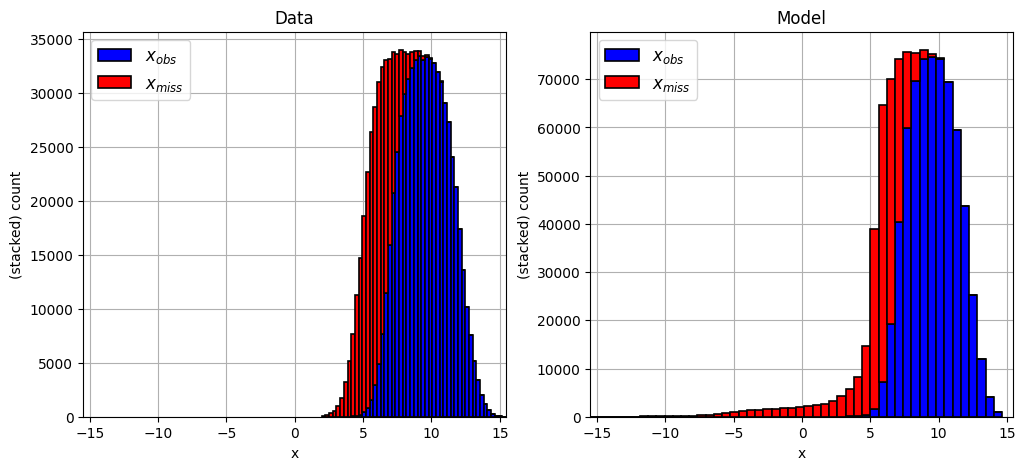

In [25]:
hist_compare_individual_entries(x_obs, x_miss, x_est_obs, x_est_miss)

In [26]:
W, b = notmiwae.sess.run([notmiwae.W, notmiwae.b])

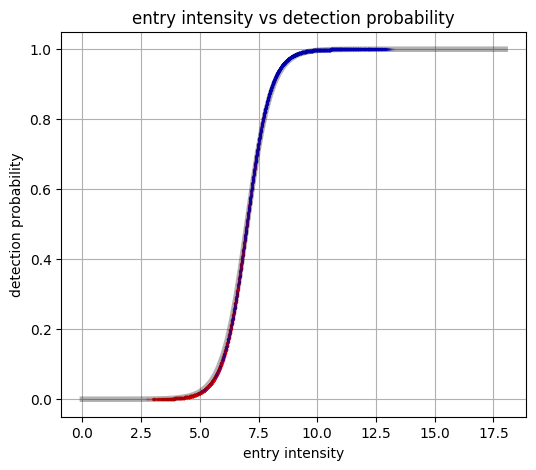

In [27]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 5))

p_obs = detection_prob[mask]
x_obs = x_data[mask]

p_miss = detection_prob[~mask]
x_miss = x_data[~mask]

n = 5_000

ax.scatter(x_miss[:n], p_miss[:n], color="red", alpha=.1, s=2)
ax.scatter(x_obs[:n], p_obs[:n], color="blue", alpha=.1, s=2)
ax.set_title("entry intensity vs detection probability")
ax.set_xlabel("entry intensity")
ax.set_ylabel("detection probability")
ax.grid(True)
ax.set_axisbelow(True)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

for n in range(W.shape[-1]):
    xs = np.linspace(0, 18, 100)
    logit = -W[0, 0, n] * (xs - b[0, 0, n])
    ys = sigmoid(logit)
    ax.plot(xs, ys, color="black", alpha=.3, linewidth=4)